# Final Project
## Predicting Physical Activity from Accelerometer Data

In the final project for this course, we are given a set of training data (train_time_series.csv) and corresponding labels (train_labels.csv). The data contain timestamps, UTC time, accuracy, and x, y, and z acceleration columns, and the labels consist of one of four classes (standing, walking, stairs down, and stairs up for 1 to 4, respectively) for every tenth observation of the training data. 

The goal of the project is to classify different physical activities with optimal accuracy. Test data is included in test_time_series.csv but the corresponding labels are unknown. Given that unverified users do not have access to the true test results, final model accuracy can only be assessed on the training data. Code run time will also be recorded. 

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

train_X = pd.read_csv('train_time_series.csv')
train_Y = pd.read_csv('train_labels.csv')
test_X = pd.read_csv('test_time_series.csv')
train_X

,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z
0,20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
1,20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554
2,20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467
3,20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
4,20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450
...,...,...,...,...,...,...,...
3739,24325,1565110305638,2019-08-06T16:51:45.638,unknown,0.024384,-0.710709,0.030304
3740,24326,1565110305738,2019-08-06T16:51:45.738,unknown,0.487228,-1.099136,-0.015213
3741,24327,1565110305838,2019-08-06T16:51:45.838,unknown,0.369446,-0.968506,0.036713
3742,24328,1565110305939,2019-08-06T16:51:45.939,unknown,0.167877,-0.802826,0.049805


We will first look at some of the available columns. The accuracy for each sample is listed as 'unknown,' and the first, unnamed column should merely serve as an index, which Pandas already provides us. We can confirm this latter point by checking that the difference between the Pandas-assigned index column and the input index column is constant. Therefore, we can reduce this dataframe to the usable columns.

In [2]:
np.mean(train_X.accuracy == 'unknown')

1.0

In [3]:
np.mean(train_X['Unnamed: 0'] - train_X.index == 20586)

1.0

Similarly, the UTC time column should not provide any extra information beyond the timestamp column. To confirm this, we convert the UTC time string to a datetime object, and convert it to the number of seconds since 1/1/1970, which is identical to the timestamp entry for each sample after converting to milliseconds. Thus, we can remove this as well.

In [5]:
dt = [datetime.strptime(t, '%Y-%m-%dT%H:%M:%S.%f') for t in train_X['UTC time']]
sec = [((dti - datetime(1970,1,1)).total_seconds()) for dti in dt]
sum(sec[i] * 1000 != train_X.timestamp[i] for i in range(len(dt)))

0

In [6]:
train_X = train_X.iloc[:, [1, 4, 5, 6]]
train_X

,timestamp,x,y,z
0,1565109930787,-0.006485,-0.934860,-0.069046
1,1565109930887,-0.066467,-1.015442,0.089554
2,1565109930987,-0.043488,-1.021255,0.178467
3,1565109931087,-0.053802,-0.987701,0.068985
4,1565109931188,-0.054031,-1.003616,0.126450
...,...,...,...,...
3739,1565110305638,0.024384,-0.710709,0.030304
3740,1565110305738,0.487228,-1.099136,-0.015213
3741,1565110305838,0.369446,-0.968506,0.036713
3742,1565110305939,0.167877,-0.802826,0.049805


With our reduced dataframe, we can begin to train our algorithm. We can test a number of different classification algorithms, but will restrict ourselves to those covered in this course, i.e. multi-class logistic regression and a random forest classifier. Support vector classifiers and k-nearest neighbors algorithms, along with neural networks, may also be applicable to this type of classification problem. We will begin by instantiating these objects with default parameters for the time being, as well as define an accuracy function used to quantify our results.

In [7]:
logistic_regression = LogisticRegression(penalty='l2', multi_class='ovr')
forest_classifier = RandomForestClassifier(max_depth=4)

In [8]:
def accuracy(estimator, X, y):
    estimator.fit(X, y)
    predictions = estimator.predict(X)
    return accuracy_score(y, predictions)

However, prior to testing our algorithms, we must address the fact that only one label sample is present for every ten acceleration samples. For an initial naive method, we can extract only the X samples corresponding to the timestamps in the Y data, but it is possible that we can better estimate the label using the information we are currently ignoring. 

In [9]:
train_Y

,Unnamed: 0,timestamp,UTC time,label
0,20589,1565109931087,2019-08-06T16:45:31.087,1
1,20599,1565109932090,2019-08-06T16:45:32.090,1
2,20609,1565109933092,2019-08-06T16:45:33.092,1
3,20619,1565109934094,2019-08-06T16:45:34.094,1
4,20629,1565109935097,2019-08-06T16:45:35.097,1
...,...,...,...,...
370,24289,1565110302030,2019-08-06T16:51:42.030,4
371,24299,1565110303032,2019-08-06T16:51:43.032,4
372,24309,1565110304034,2019-08-06T16:51:44.034,4
373,24319,1565110305037,2019-08-06T16:51:45.037,4


In [10]:
train_Y = train_Y.loc[:, ['timestamp', 'label']]
train_Y

,timestamp,label
0,1565109931087,1
1,1565109932090,1
2,1565109933092,1
3,1565109934094,1
4,1565109935097,1
...,...,...
370,1565110302030,4
371,1565110303032,4
372,1565110304034,4
373,1565110305037,4


In [11]:
train_X_subset = train_X.iloc[[train_X.timestamp[i] in train_Y.timestamp.values for i in range(len(train_X.timestamp))], :]
print(all(train_X_subset.timestamp.values==train_Y.timestamp.values))
train_X_subset

True


,timestamp,x,y,z
3,1565109931087,-0.053802,-0.987701,0.068985
13,1565109932090,0.013718,-0.852371,-0.000870
23,1565109933092,0.145584,-1.007843,-0.036819
33,1565109934094,-0.099380,-1.209686,0.304489
43,1565109935097,0.082794,-1.001434,-0.025375
...,...,...,...,...
3703,1565110302030,-0.641953,-1.469177,0.301041
3713,1565110303032,-0.171616,-0.366074,-0.059082
3723,1565110304034,0.401810,-1.077698,0.258911
3733,1565110305037,0.330338,-1.470062,0.303894


Another modification necessary is to extract only the values of the relevant columns. We will do this using the iloc subsetting method and the .values attribute for both X and Y.

In [12]:
X = train_X_subset.iloc[:, 1:].values
Y = train_Y.label.values

We can now train the classifiers we instantiated earlier on this X and Y data. We quantify our results using the cross_val_score method from sklearn.model_builder using 10-fold cross-validation. 

Logistic Regression Average Score: 0.5736130867709817
Random Forest Average Score: 0.9094594594594596


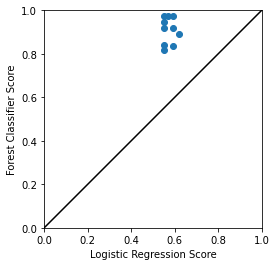

In [13]:
logistic_scores = cross_val_score(logistic_regression, X, Y, cv=10, scoring=accuracy)
rf_scores = cross_val_score(forest_classifier, X, Y, cv=10, scoring=accuracy)
print("Logistic Regression Average Score:", np.mean(logistic_scores))
print("Random Forest Average Score:", np.mean(rf_scores))

# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(logistic_scores, rf_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Logistic Regression Score")
plt.ylabel("Forest Classifier Score")

plt.show()

These results show that the random forest classifier performs better than the logistic regression classifier. We can now vary some parameters in each classifier to see if we can improve the scores.

In [14]:
logistic_regression = LogisticRegression(penalty='none', multi_class='ovr', max_iter = 10000, tol=0.000001)
forest_classifier = RandomForestClassifier(max_depth=7)

In [15]:
logistic_scores = cross_val_score(logistic_regression, X, Y, cv=10, scoring=accuracy)
rf_scores = cross_val_score(forest_classifier, X, Y, cv=10, scoring=accuracy)
print("Logistic Regression Average Score:", np.mean(logistic_scores))
print("Random Forest Average Score:", np.mean(rf_scores))

Logistic Regression Average Score: 0.5788051209103842
Random Forest Average Score: 1.0


Clearly, even without regularization and with much higher maximal iteration and smaller tolerance, the random forest classifier still outperforms the logistic regression one-vs-all classifier. It is possible that the RF classifier is overfitting the data, but given our use of cross-validation, this is unlikely. We can perform a more systematic depth search for the random forest classifier as follows:

Text(0, 0.5, 'Mean Cross-Validation Score for 3 Validation Sets')

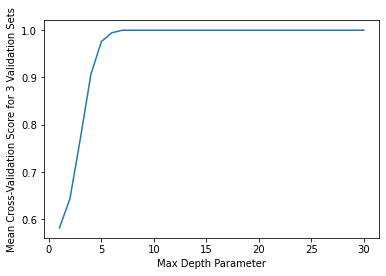

In [16]:
max_depths = np.linspace(1, 30, 30, endpoint=True)
score = []
for max_depth in max_depths:
    forest_classifier = RandomForestClassifier(max_depth=max_depth)
    rf_scores = cross_val_score(forest_classifier, X, Y, cv=10, scoring=accuracy)
    score.append(np.mean(rf_scores))
plt.plot(max_depths, score)
plt.xlabel('Max Depth Parameter')
plt.ylabel('Mean Cross-Validation Score for 3 Validation Sets')

We can see than any value of max_depth greater than ~7 appears to give us perfect cross-validation accuracy. While we appear to be able to reliably predict activity with a random forest classifier, we are still throwing away 90% of the data through our subsetting of the train_X dataset. It may be possible to use neighboring points with a sliding-window approach to estimate labels based not only on the immediate x, y, and z acceleration, but also nearby points. For example, we can average the five nearest points (i.e. 2 before and 2 after each data point with a matching timestamp in Y) as follows.

In [17]:
X_avg = []
for i in train_X_subset.index:
    X_avg.append(np.mean(train_X.iloc[i-2:i+3, 1:], axis = 0))
X_avg = np.array(X_avg)
X_avg

array([[-0.04573364, -0.99911804,  0.12687073],
       [-0.03197632, -0.99451599,  0.06184387],
       [ 0.12408447, -1.0053833 , -0.02505188],
       ...,
       [ 0.10877991, -0.95152588,  0.18502808],
       [ 0.40496216, -1.11669922,  0.06250916],
       [ 0.40888977, -0.92079163,  0.04049683]])

In [20]:
logistic_regression = LogisticRegression(penalty='none', multi_class='ovr', max_iter = 10000, tol=0.000001)
forest_classifier = RandomForestClassifier(max_depth=5)

In [21]:
logistic_scores = cross_val_score(logistic_regression, X_avg, Y, cv=10, scoring=accuracy)
rf_scores = cross_val_score(forest_classifier, X_avg, Y, cv=10, scoring=accuracy)
print("Logistic Regression Average Score:", np.mean(logistic_scores))
print("Random Forest Average Score:", np.mean(rf_scores))

Logistic Regression Average Score: 0.5946657183499289
Random Forest Average Score: 0.9893314366998578


By using the neighboring two nearest points to each recorded timepoint, we can see that the logistic regression cross_validation score increases around 2%. Changing the multiclass method from one-vs-all to multinomial does not appear to have a significant improvement. 

In [25]:
logistic_regression = LogisticRegression(penalty='none', multi_class='multinomial', max_iter = 10000, tol=0.000001)
forest_classifier = RandomForestClassifier(max_depth=5)
logistic_scores = cross_val_score(logistic_regression, X_avg, Y, cv=10, scoring=accuracy)
rf_scores = cross_val_score(forest_classifier, X_avg, Y, cv=10, scoring=accuracy)
print("Logistic Regression Average Score:", np.mean(logistic_scores))
print("Random Forest Average Score:", np.mean(rf_scores))

Logistic Regression Average Score: 0.5972972972972973
Random Forest Average Score: 0.9785917496443812


Perhaps we can do better with a systematic search. Let's vary this weighting window from 0 to 5 in either direction, removing the last sample and the first if the boundary goes beyond the endpoints of the array.

Text(0, 0.5, 'Mean cross-validation score')

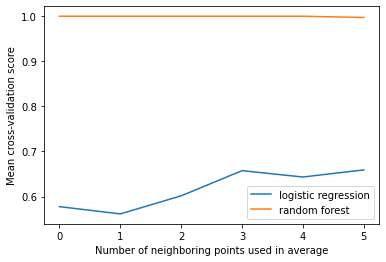

In [27]:
logistic_regression = LogisticRegression(penalty='none', multi_class='ovr', max_iter = 10000, tol=0.000001)
forest_classifier = RandomForestClassifier(max_depth=7)

scores_lr = []
scores_rf = []
for depth in range(6):
    X_avg = []
    if depth > 3:
        for i in train_X_subset.index[1:-1]:
            X_avg.append(np.mean(train_X.iloc[i-depth:i+depth+1, 1:], axis = 0))
        Y_subset = Y[1:-1]
    else:
        for i in train_X_subset.index[:-1]:
            X_avg.append(np.mean(train_X.iloc[i-depth:i+depth+1, 1:], axis = 0))
        Y_subset = Y[:-1]
    X_avg = np.array(X_avg)
    
    logistic_scores = cross_val_score(logistic_regression, X_avg, Y_subset, cv=10, scoring=accuracy)
    rf_scores = cross_val_score(forest_classifier, X_avg, Y_subset, cv=10, scoring=accuracy)
    
    scores_lr.append(np.mean(logistic_scores))
    scores_rf.append(np.mean(rf_scores))

plt.plot(range(6), scores_lr, label="logistic regression")
plt.plot(range(6), scores_rf, label="random forest")
plt.legend()
plt.xlabel('Number of neighboring points used in average')
plt.ylabel('Mean cross-validation score')

With this method, we see that the RF classifier appears to be unaffected by our modification of the data, while the logistic regression classifier increases to an accuracy around 0.7 and levels off. Further changes to the methodology could include the use of weighted averages rather than simple averages. Let's next explore the use of an exponentially weighted average, wherein we initialize the EWA at 0 and update it at each sample of x as $EWA := \beta * EWA + (1-\beta) * X_i$.

In [28]:
X_ewa = []
ewa = np.array([0, 0, 0])
beta = 0.9
for i in range(len(train_X)):
    ewa = beta * ewa + (1-beta) * train_X.iloc[i, 1:]
    X_ewa.append(ewa)
X_ewa = np.array(X_ewa)
X_ewa

array([[-6.48498535e-04, -9.34860229e-02, -6.90460205e-03],
       [-7.23037720e-03, -1.85681610e-01,  2.74124146e-03],
       [-1.08560944e-02, -2.69238998e-01,  2.03137970e-02],
       ...,
       [ 3.41590478e-01, -1.02719481e+00,  1.06514489e-01],
       [ 3.24219150e-01, -1.00475792e+00,  1.00843508e-01],
       [ 3.60731866e-01, -1.00338644e+00,  9.42564721e-02]])

In [29]:
X_ewa_subset = X_ewa[[train_X.timestamp[i] in train_Y.timestamp.values for i in range(len(train_X.timestamp))], :]
X_ewa_subset.shape

(375, 3)

After subsetting this average to the matching data points, we can test it on our algorithms. 

In [32]:
logistic_regression = LogisticRegression(penalty='none', multi_class='ovr', max_iter = 10000, tol=0.000001)
forest_classifier = RandomForestClassifier(max_depth=7)

logistic_scores = cross_val_score(logistic_regression, X_ewa_subset, Y, cv=10, scoring=accuracy)
rf_scores = cross_val_score(forest_classifier, X_ewa_subset, Y, cv=10, scoring=accuracy)
print("Logistic Regression Average Score:", np.mean(logistic_scores))
print("Random Forest Average Score:", np.mean(rf_scores))

Logistic Regression Average Score: 0.7467994310099574
Random Forest Average Score: 1.0


This method appears to further improve our cross-validation accuracy on the logistic model. Given that the random forest is consistently performing much better than the logistic regression model, let's continue only with the random forest and explore some hyperparameter dependencies, such as the min_samples_leaf and min_samples_split parameters.

In [75]:
forest_classifier = RandomForestClassifier(max_depth=7, min_samples_leaf = 2, min_samples_split=3)
rf_scores = cross_val_score(forest_classifier, X_ewa_subset, Y, cv=10, scoring=accuracy)
print("Random Forest Average Score:", rf_scores.mean())

Random Forest Average Score: 0.9275960170697013


In [76]:
forest_classifier = RandomForestClassifier(max_depth=7, min_samples_leaf = 2, min_samples_split=3)
rf_scores = cross_val_score(forest_classifier, X, Y, cv=10, scoring=accuracy)
print("Random Forest Average Score:", rf_scores.mean())

Random Forest Average Score: 0.909317211948791


In [77]:
forest_classifier = RandomForestClassifier(max_depth=11, min_samples_leaf = 2, min_samples_split=3)
rf_scores = cross_val_score(forest_classifier, X_ewa_subset, Y, cv=10, scoring=accuracy)
print("Random Forest Average Score:", rf_scores.mean())

Random Forest Average Score: 0.9251066856330015


In [78]:
forest_classifier = RandomForestClassifier(max_depth=11, min_samples_leaf = 2, min_samples_split=3)
rf_scores = cross_val_score(forest_classifier, X, Y, cv=10, scoring=accuracy)
print("Random Forest Average Score:", rf_scores.mean())

Random Forest Average Score: 0.9090327169274538


From the above, we see that above some threshold, there does not seem to be a substantial improvement from increasing the max_depth. However, it appears that preventing the tree from making more splits by placing more stringent requirements on the splitting parameters decreases the accuracy. Therefore, it is possible that we may be slightly overfitting the data, since this could indicate that there is a single leaf for each data point, despite our use of cross-validation. If we look back at our experimental data, we see the following distribution of classes:

In [62]:
print(sum(Y == 1))
print(sum(Y == 2))
print(sum(Y == 3))
print(sum(Y == 4))

27
213
88
47


Clearly, class 2 (walking) is by far the most abundant. With this skewed class distribution, using the balanced_accuracy measure may be more applicable to our data than conventional accuracy. Let's perform a systematic parameter search with this new accuracy method.

In [59]:
def balanced_accuracy(estimator, X, y):
    estimator.fit(X, y)
    predictions = estimator.predict(X)
    return balanced_accuracy_score(y, predictions)

In [79]:
params = {
    'max_depth': range(1, 15),
    'min_samples_leaf': range(1, 6),
    'min_samples_split': range(2, 7)
}
rf = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring=balanced_accuracy, cv=10)
rf.fit(X_ewa_subset, Y)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 15),
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(2, 7)},
             scoring=<function balanced_accuracy at 0x0000023D7DA38730>)

Let's now look at our results. Specifically, we'll focus on the mean_test_score parameter of cv_results_. We'll also reshape the (350,) array to a (14, 5, 5) array to make interpretation easier.

In [80]:
rf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [81]:
res = rf.cv_results_['mean_test_score'].reshape(14,5,5)
print(res)

[[[0.3375     0.32057449 0.33414141 0.33897727 0.3261553 ]
  [0.32171086 0.32682449 0.35050505 0.33657197 0.31729167]
  [0.34668561 0.34212753 0.33022727 0.33629419 0.32337753]
  [0.35025253 0.34189394 0.33747475 0.33247475 0.33247475]
  [0.34580808 0.34080808 0.34001894 0.32724116 0.33876894]]

 [[0.54757846 0.55163149 0.58238005 0.57118957 0.53452291]
  [0.53132846 0.50871483 0.52079816 0.57046988 0.47577291]
  [0.46822872 0.47431457 0.46299513 0.46822872 0.49021735]
  [0.42264791 0.43667569 0.44598124 0.42799513 0.44098124]
  [0.39015783 0.41132846 0.40285624 0.40375902 0.39688402]]

 [[0.78249008 0.7872123  0.78125902 0.75420094 0.70496483]
  [0.72042569 0.70350649 0.72420094 0.72756854 0.69654221]
  [0.60993957 0.61334235 0.58612013 0.58445346 0.62334235]
  [0.47910624 0.4581241  0.48445346 0.49612013 0.50056457]
  [0.41104076 0.41931457 0.40723124 0.39618957 0.41431457]]

 [[0.88582341 0.88769841 0.87492063 0.85183983 0.78867965]
  [0.86556457 0.83482594 0.83898268 0.82238546 0.7

Let's extract the parameter combinations which gave us maximal cross-validation accuracy.

In [87]:
idx = rf.cv_results_['mean_test_score'] == 1
depth = []
leaf = []
split = []
for i,val in enumerate(idx):
    if val:
        depth.append(rf.cv_results_['param_max_depth'][i])
        leaf.append(rf.cv_results_['param_min_samples_leaf'][i])
        split.append(rf.cv_results_['param_min_samples_split'][i])
print("Depth:\n")
print(depth)
print('\n')
print("Leaf:\n")
print(leaf)
print('\n')
print("Split:\n")
print(split)
print('\n')

Depth:

[7, 7, 8, 8, 9, 11, 11, 12, 13, 13, 14]


Leaf:

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Split:

[2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2]




From these values, we can tell that depths above 7, samples/leaf of 1, and minimum number of samples required to split of 2 or 3 provides optimal cross-validation performance. With this in mind, we can construct our final model and fit it to the training data.

In [93]:
forest_classifier = RandomForestClassifier(max_depth=11, min_samples_leaf = 1, min_samples_split=2)
forest_classifier.fit(X_ewa_subset, Y)
accuracy_score(forest_classifier.predict(X_ewa_subset), Y)

1.0

With our final model architecture selected and trained, we'll now re-run all the relevant pieces of code, i.e. importing libraries and initial data, subsetting, and model training. We'll also have to convert the training data to an exponentially-weighted average before using our fitted model to predict the labels. We'll use the time module to time the total runtime of the code.

In [104]:
%reset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

tic = datetime.now()
train_X = pd.read_csv('train_time_series.csv')
train_X = train_X.iloc[:, [1, 4, 5, 6]]
train_Y = pd.read_csv('train_labels.csv')
train_Y = train_Y.loc[:, ['timestamp', 'label']]
test_X = pd.read_csv('test_time_series.csv')
Y = train_Y.label.values
X_ewa = []
ewa = np.array([0, 0, 0])
beta = 0.9
for i in range(len(train_X)):
    ewa = beta * ewa + (1-beta) * train_X.iloc[i, 1:]
    X_ewa.append(ewa)
X_ewa = np.array(X_ewa)
X_ewa_subset = X_ewa[[train_X.timestamp[i] in train_Y.timestamp.values for i in range(len(train_X.timestamp))], :]

forest_classifier = RandomForestClassifier(max_depth=11, min_samples_leaf = 1, min_samples_split=2)
forest_classifier.fit(X_ewa_subset, Y)

test_X = test_X.iloc[:, -3:]
X_ewa_test = []
ewa = np.array([0, 0, 0])
for i in range(len(test_X)):
    ewa = beta * ewa + (1-beta) * test_X.iloc[i, :]
    X_ewa_test.append(ewa)
X_ewa_test = np.array(X_ewa_test)
predictions = forest_classifier.predict(X_ewa_test)
toc = datetime.now()

print("Total runtime: ", toc-tic)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Total runtime:  0:00:02.739975


Ultimately, our code runs in 2.7 seconds. Given that we don't have the true labels for our testing set, it is difficult to quantify our final model performance. Even so, use of 10-fold cross-validation provides evidence that the model should perform well on the testing data. Certain improvements could still potentially be made to reduce total runtime. For example, using the exponentially weighted average did not appear to significantly improve model performance beyond data included in the instantaneous triaxial accelerations. Therefore, to reduce needed computation and data modification, it may not be necessary to use this methodology.

As a last remark, lets examine the distribution of our predictions and compare that to the input dataset. 

In [109]:
print(sum(predictions == 1))
print(sum(predictions == 2))
print(sum(predictions == 3))
print(sum(predictions == 4))

153
666
287
144


In [110]:
print(sum(predictions == 1)/sum(Y==1))
print(sum(predictions == 2)/sum(Y==2))
print(sum(predictions == 3)/sum(Y==3))
print(sum(predictions == 4)/sum(Y==4))

5.666666666666667
3.1267605633802815
3.2613636363636362
3.0638297872340425


In [113]:
print(sum(predictions == 1)/len(predictions))
print(sum(predictions == 2)/len(predictions))
print(sum(predictions == 3)/len(predictions))
print(sum(predictions == 4)/len(predictions))

0.1224
0.5328
0.2296
0.1152


In [114]:
print(sum(Y == 1)/len(Y))
print(sum(Y == 2)/len(Y))
print(sum(Y == 3)/len(Y))
print(sum(Y == 4)/len(Y))

0.072
0.568
0.23466666666666666
0.12533333333333332


Given this qualitative similarity, it certainly seems possible that our training and testing data was drawn from the same distribution, suggesting that our model accuracy may be high as expected.